# Trees, Particles and Boundaries

This chapter address two types of advanced topics. One is how to build Trees. Two strategies are illustrated, (i) the Warren and Salmon implementation of the Barnes and Hut tree, based on the Hashing technique, and (ii) the standard KD tree, already implemented in the SciPy Libraries. The second topic of the chapter is how to build a Boundary Element solver for fluid-dynamics. The general theory of how to implement a multiphase flow is illustrated, and then an example of how to calculate the drag over a rigid body using quadratic triangular boundary elements is detailed with the specific solution for a flat ellipsoid. It is shown that a standard implementation of the BEM technique requires dense matrices, therefore scaling as $N^2$, where N is the number of the boundary Elements. To write a tree-based solver allows obtaining a fast solver that scales almost linearly with N.


#### Bad programmers worry about the code. Good programmers worry about data structures and their relationships. 
Linus Torvalds

In 1993 a revolution happened in the domain of Software Games. Most games that involved many players and dynamics were in two-dimensions. When in 3D they were very slow. The game *Doom* changed the entire picture. Suddenly teenagers could play in first person in 3D moving in a dungeon at an amazing speed, from room to room. The breakthrough that brought to this revolution was the introduction of Binary Space Partitioning (BPS). 

The idea behind it is the old **divide and conquer** algorithm. Instead of storing 3D information entirely, in Doom the space was represented by a binary tree that at every level zooms 2 times smaller cells. The leaves of the tree were convex polygons, without any further division. The way in which this algorithm allowed such a fast representation was to **traverse** the tree by starting at the root node and the drawing the child nodes recursively, level by level. To decide which child node to draw first it was essential to know the position of the closest polygons to the camera, which had to be quickly accessed and drawn until the screen was filled, avoiding to draw objects that were not visible to the player. 

This idea of binary Tree went since then much further and has become the standard way in which are modelled many body problems in Astrophysics (gravitational), Aerodynamics (turbulence), Electrostatics and many more. Let's look now at how they appear in the Geodynamics equations. In the past section we have seen how Stokes Flow (and so many other physics problems that are characterized by a *potential*) can be described by the summation, or integration, of many singular solutions. In this chapter we dive into the computational challenge of integrating these *characteristic solutions*. 

The far field $1/r=r^{-1}$ decay of the Green Functions of Diffusion and Stokes equations has general analogues in physics in the gravity and electromagnetic potentials, which decay as $r^{-1}$ and as $e^{ikr}/r$ respectively. Systems controlled by these potentials, and forces, display what is normally called in physics a *long range interaction*, which means that the decay is sufficiently slow that the total effect of the many-but-many far sources will give a comparable contribution to stronger-but-few close sources. This makes these problem harder to solve efficiently because the far field component has to calculated carefully. When this very general phenomenon, this all-to-all interaction, appears we speak about the *many body* problem. 
 
Problems of this specie arose first in computational physics when trying to calculate the evolution of N celestial bodies. For example how 100,000 stars would move in the space to form a galaxy, or whatever else. 100,000 ($10^5$) bodies that interact each with each other have 10,000,000,000 ($10^{10}$) interactions. In general the number of forces that should be calculated is $N^2$, if N is the number of bodies. In this chapter I will show some examples of how these calculations can be approximated with a small error reducing the number of forces to calculate to a number of the order of $N log N$ . We will use trees to organize the sources and separating the close and far field contributions.  
 

## Tree building

Many implementations exist in the literature on how to build trees that organize a large set of data. We will limit ourself to some structures that are particularly suited for implementation using NumPy or for which an efficient parallel implementation is well documented. 

### The Barnes and Hut tree

Barnes and Hut defined the three-dimensional tree structure by the following properties:

1. The space where the model is calculated is a large cube, split into an octree of cubical sub-cells so that every cell has eight descendants equal in size and shape.

2. There is a maximum number $m$ of particles contained in each terminal cell (=leaf). If a node has less or equal to $m$ particles it is not further divided. We will consider only the case in which m=1, in this way each leaf will contain either one or zero particles.

The way in which Barnes and Hut described the construction of their tree was recursive, i.e. they start with an empty tree and add one body after the other, each time adding a new branch or leaf. This procedure can be obtained by finding the most refined element of the current tree which contains the body, and then to add the body directly to that element, either by refining it further or by simply inserting the body. This method is however not so suitable to be vectorized so easily. This limitation can be overcome by using a Cython implementation, or by using a more modern algorithm, from Warren and Salmon, that intensively exploits the NumPy library, or by using the existing **KDTree** features added to the Spatial library of the standard SciPy Module.

## Hashing Space Organization

The simplest way to built tree whose structure reflects the position of a set of particles is by dividing the space into smaller and smaller region until not more than one particle remains in one cell. In many problems of physical interest the particles represents quantities that are not homogeneously distributed. For example *stars* in computational astrophysics or hydrated rocks in geodynamics subduction modeling. For these reasons the structure of the tree in real cases is highly heterogeneous. In 1993 Michael S. Warren and John K. Salmon, two students at the University of California in Santa Barbara and at the California Institute of Technology, respectively, developed a simple and very elegant formulation to build and manage trees that performs well also with very clustered and heterogeneous particles distributions. 

Several innovative ideas were in their paper. The first was to use **hashing** for accelerating tree building and to simplify parallelization.  For example if we have a number of points masses in the space, we can store the center of mass by averaging the center of masses of the daughters cells. The way this is handled in programming is by storing the addresses of each cell by *pointing* to *children* cells, along with data referring to that cells, summarizing the global effects of the daughters. This is a very complex structure and requires much programming to be organized and parallelized on a large system. Hashing is a simple way to overcome these complications. It is based on the extracting the unique tree structure from the x,y, z coordinates themselves. 

Hashing is a key scheme that provides a uniform addressing mechanism for homogeneously placed data. It works simply by translating the $x$, $y$ and $z$ coordinates into a binary form, and then to create a long integer number by alternating the digits ($0$ or $1$) for each of the coordinates. E.g. if $x$ in binary is $0110$, $y$ is $1001$ and $z$ $1010$, the hashing key number will be $011.100.101.010$, i.e the key is $1834$ in decimals, with integers of $12$ digits. The main advantages of calculating the keys associated to each element is that we can now order all the elements because particles whose sorted addresses are near to each other are also near in space. 

Let's look at an example, which always helps to understand techniques. I create here a routine that takes three $x$,$y$,$z$ coordinates (renormalized to $1$), transform them in integer that indicates in which cell in a $2^{level} \times 2^{level} \times 2^{level}$ virtual mesh are, and then transform the three numbers in a hash-key binary, merges the three hash-keys in a unique index that is returned. In this way we have a unique integer that we can use to order a large number of particles distributed in space.

In [7]:
import numpy as np

def createHash(x,y,z,level):
    cellSize = 0.5**(level+1)

    # so all binaries have the same length
    x += 1; y += 1; z += 1 
    xb=bin(int(x/cellSize))
    yb=bin(int(y/cellSize))
    zb=bin(int(z/cellSize))

    # indeces from three because xb, yb, zb start with 0b1
    hb = "".join(xb[i]+yb[i]+zb[i] for i in range(3,level+3))
 
    return int(hb, 2)

Where we used two little tricks. One has been to increase $x$,$y$,$z$ of one so that the binary starts from one. 
This can be simply called with one set of numbers, e.g. :

In [8]:
x = np.random.rand()
y = np.random.rand()
z = np.random.rand()
level = 10

hashKey = createHash(x,y,z,level)

Using Hash-Keys as a unique index in an n-dimensional space offers several advantages at the same time:

1. The ordering allows immediately to know which set of particles are new the one that we are analyzing (just the ones that have a keys just before and after the Hash-Key of the particle)

2. The ordering allows a perfect parallelization even for highly heterogeneous particle distribution. Given $N$ processors and M particles, it is possible to elaborate the first $M/N$ particles in the first processor, the second $M/N$ in the second processor, and so on. In this way automatically near particles will be at the same processors. 

Both characteristics are important in most calculations because the majority of inter-particle force, or potential, decays with distance. For this reason one needs to calculate more accurately the force (or potential) of the closer neighbors and one can approximate (and sometime even neglect) the contribution of  the very far particles. 

Hashing was initially introduced by Irene Gargantini, a physicist from Milan, in Italy, who worked for many years at IBM in Switzerland before moving to Canada where she became the first women to held a chair in a computer science department. She invented the Hash-Keys method for creating oct-tree much faster than the method used at that time, based on pointers. Since hashed trees occupy less memory and are faster to build, they are the ideal tool to use in parallel programming. Her initial paper, in 1982, (Gargantini, 1982) was followed by hundreds of works that applied her approach to all the parallel algorithms existing at her time.

Let's now see a simple example that illustrates why Hash-Keys are so powerful. We can create a set of few thousands random points in space and by using the *color* feature of *matplotlib scatterplot* illustrate how this represents a natural order of points in space:

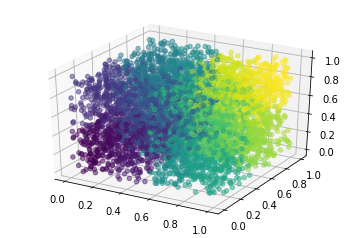

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

nPoints=5000
x = np.random.rand(nPoints)
y = np.random.rand(nPoints)
z = np.random.rand(nPoints)
level = 10
hashKey=np.zeros(nPoints,dtype=np.int64)
for i in np.arange(nPoints):
    hashKey[i] = createHash(x[i],y[i],z[i],level)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=hashKey, alpha=0.5)
plt.show()

Clearly this implementation is very slow, as the Hash-Keys could be created in one with a unique vectorized operation. The implementation is left to the reader in one of the exercises at the end of the chapter.

## Python Spatial KD Tree

Binary trees have also been implemented into the Scientific Python Library (SciPy), within the `spatial` module and can be loaded with the instruction `from scipy import spatial`. This implementation allows space partitioning of data structure. The functions of this module are highly optimized and based on the standard k-d Tree Model. k stays for the number of dimensions in which we physical space exists. For example 3-d trees in three dimensions. 

The idea behind **k-d Trees** is to split the domain in two at different dimension for every level. In 3D for example at the first level the domain will be a split by an axis in the x direction, at the second level in the y direction, at the third level in the z direction and then back to x. The axis and splitting point are chosen to be the *median* particle. Although the algorithm has been written for any dimension $k$, it is really efficient only at low dimensions (less than 10). To search for high-dimension nearest-neighbors is still an open scientific problem.

Let's for example see how one can calculate the interaction of a large number ($100,000$ in this case) of rigid particles suspended in a fluid. We know from previous lectures  that in the Stokes flow approximation a rigid spherical particle creates a flow described by a single *Stokeslet*. We have also observed  how this property can be exploited to program much more efficiently the far-field vs. close-field particle interaction. 

At that point it is necessary to either copy the structure of the entire tree on all nodes, which is a valid solution until the size of the tree is manageable, or to *translate* the pointers from one node to the other, which is complicated. 

## Boundary Based Simulations

Most of this book has been devoted on how to accelerated codes that calculate the solution of the momentum or energy equation in the entire modeled space. This is the simplest and most intuitive approach to solving continuum mechanics equations, nevertheless there are better approaches for a large number of problems. In fact many physical equations that apply to the three-dimensional space are based the minimization or maximization of some function. For example every system characterized by many particles like a gas (made of many molecules) will tend towards the maximization of the entropy. Even systems far from mechanics still have to obey to such laws. For example the electrical properties of a metal is determined by the motion of many interacting electrons and will always tend towards the minimization of the associated quantum energy functional. Sometimes this results in surprising laws. For example in optics the Snell's law that determines the incidence angle of a ray of light through a boundary between two system with different refractive indices ($n_1 \sin \theta_1 = n_2 \sin \theta_2$) it is in turn the solution of the minimization problem: _what is the trajectory that minimizes the time necessary to go from the source to the target?_, as brilliantly found by Fermat in 1662.

Similarly for Stokes flow we have a principle that affirms that the flow solution of the momentum equation will be the one that minimizes energy dissipation (e.g. Pozrikidis 1992). By using this principle it is therefore possible to write equations that are valid only at the boundary between two regions, each with an homogeneous density and viscosity characteristics. The first person who found the \emph{Boundary Integral} expression for the multiphase viscous flow was Olga Ladyzhenskaya, a great soviet mathematician who first developed a great passion for mathematics from her father, a mathematics teacher, and then was blocked by the soviets who arrested and killed her father (while she was still a teenager) and prohibited her from studying math at the Leningrad University. It was only after the death of Stalin that she was allowed to present her PhD thesis and continue her career as a mathematician. She has left us with the first rigorous proof of the convergence of a finite difference method for the Navier-Stokes equations and for the first clear expression of the Boundary Element Method applied to Viscous Flow. Her major findings can be found in her famous book, *The Mathematical Theory of Viscous Incompressible Flow* from 1969. 

***

The theory behind boundary element is mathematically very advanced, I will therefore embed only a synthesis. Taking a domain where Stokes is the dominating velocity and the internal viscosity is $\eta$, the velocity at every point inside the domain $D$ can be written as the sum of surface integrals of the velocity for a specific *kernel*. Kernels used in the Boundary Element Method are also called Green Functions. $G_{ij}$ and $T_{ijk}$ are the steady Green's functions (**Stokeslet**} and **Stresslet**) for velocity and stress respectively that we introduced previously.>  

The fundamental expression that relates the traction applied to the boundary is $f_i({\bf x}) = \sigma_{ik}({\bf x}) n_k({\bf x})$ with the velocity of every point at the boundary $u_{i}({\bf x})$ is:

\begin{align}
- \frac{1}{8 \pi \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n_k G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) + \frac{1}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n_k T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x}) \notag \\
&=\begin{cases}
u_i({\bf x}_o) & \text{if ${\bf x}_o \in D$,}\\
0 & \text{otherwise}\\ 
\end{cases}
\label{eq:int1null} 
\end{align}

Where the integral of the traction is called **Single Layer** and the integral of the velocity **Double Layer**. 

The expression in equation above was used by Ladyzhenskaya (see Ladyzhenskaya, 1969, pag. 75), to find the expression that relates velocity and stress on the boundary between two fluids with different viscosity. Formally, given a domain $D$ and its boundary $\partial D$, with viscosity $\eta$ inside $\partial D$ and $\lambda \eta$ outside, we obtain inside $\partial D$:

\begin{eqnarray}
u_j({\bf x}_o) = - \frac{1}{8 \pi \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n^{in}_k({\bf x}) G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) +\notag
\\ \frac{1}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n_k T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x}) 
\end{eqnarray}

and outside $\partial D$:

\begin{eqnarray}
u_j({\bf x}_o) = \frac{1}{8 \pi \lambda \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n^{out}_k({\bf x}) G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) + \notag \\
- \frac{1}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n_k T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x})
\end{eqnarray}

When the point $x$ lies on $\partial D$ a jump condition establishes that the two above equations become:

\begin{eqnarray}
\frac{1}{2} u_j({\bf x}_o) = - \frac{1}{8 \pi \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n^{in}_k({\bf x}) G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) + \notag \\ \frac{1}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n_k T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x}) \\
\frac{1}{2} u_j({\bf x}_o) = \frac{1}{8 \pi \lambda \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n^{out}_k({\bf x}) G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) + \notag \\
- \frac{1}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n_k T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x})
\end{eqnarray}

hence summing the two equations:

\begin{eqnarray}
\frac{1+\lambda}{2} u_j({\bf x}_o) = \frac{1}{8 \pi \eta} \int_{\partial D} \Delta f_i({\bf x}) G_{ij} ({\bf x},{\bf x}_o) &dS({\bf x}) + \notag \\
- \frac{1 - \lambda}{8 \pi} \int_{\partial D} u_{i}({\bf x}) n^{out}_k({\bf x}) T_{ijk} ({\bf x},{\bf x}_o) dS({\bf x})
\end{eqnarray}

Where $\Delta f_i({\bf x})$ represents the jump in the traction between inside and outside the boundary  $\Delta f_i({\bf x})=\sigma^{out}_{ik}({\bf x}) n^{out}_k({\bf x})+\sigma^{in}_{ik}({\bf x}) n^{in}_k({\bf x})=[\sigma^{out}({\bf x})-\sigma^{in}_{ik}({\bf x}) ]n^{out}_k({\bf x})$. An extensive literature about extrapolating the differential traction at boundaries for fluid-dynamic systems exist. When modelling systems with different buoyancy between inside and outside the boundary, one can simply write: $\Delta f \left({\bf x}\right) = \Delta \rho \, \vg \cdot {\bf x}  n^{out}_i({\bf x})$. If surface tension is present one has to add $\Delta f_i({\bf x})=\gamma n^{out}_i({\bf x})$. 

An intriguing characteristic of this last equation is that the double layer appears only when the viscosity inside and outside the boundary $\partial D$ is different. One can show how one obtains in this case the traditional Stokes equation for constant viscosity. 

***

## Drag over a rigid particle

In order to understand how the integral equations of the previous sectoin can be calculated numerically, let's start from the simplest case, the one of the drag over a rigid object. Since in this case the object does not deform, we need to calculate only the \emph{Single Layer} integral to know the resistance.The discretized expression associated to the integral expression introduced in the previous section is called *The Boundary Element Method* and consists in dividing the surface of interest in elements, in our case triangles, calculate the integrals on each triangle separately, and then sum all of them. In the case of a rigid particle the viscosity inside the particle is virtually infinite, and therefore the **Double Layer** integral disappears:

\begin{equation}
u_j({\bf x}_o) = \frac{1}{8 \pi \eta} \int_{\partial D} \sigma_{ik}({\bf x}) n_k({\bf x}) G_{ij} ({\bf x},{\bf x}_o) dS({\bf x})
\end{equation}

Where the positive sign in front of the integral indicates that the flow calculated is outside the domain. The drag over a rigid particles can be described with a $3 \times 3$ matrix, usually called *Grand Resistance Matrix* (see Pozrikidis, 1992). This matrix is symmetric and has the properties of a tensor, i.e. it depends on the particles characteristics and position, and not by the reference system. The assumption of rigidity is essential, as there is no single tensor able to describe the interaction between a deforming body and the surrounding fluid in Stokes flow. 

As for the lattice based techniques, there are several *orders* of precision to calculate the integrals. The most general choices are (i) first order, (ii) second order, (iii) analytical integration. Also spectral techniques are often employed, particularly in seismology. I will show here how to calculate this integral using second order boundary element. This gives a much greater precision than first order for objects displayed a pronounced curvature, like particles immersed in a fluid. This is done by describing every surface triangle with 6 nodes, three at the triangle corners and three at the mid-face points, as described in \fig{fig:quadraticIntegrationTriangle}. In a quadratic integration the integral over a full triangle is split in the four linear integrals shown in the figure.

insert quadraticTriangulation.pdf here: Representation of a Quadratic Triangular Boundary Element that is used in the calculation of the integral over the surface of a particle. The total integral, in a quadratic approximation, is expressed by the sum of the linear integral on each of the four triangles of the figure. The singular integral of the \emph{influence} of a triangle on itself is calculated by a loop summation over the six segments composing the boundaries of the triangle. 


Starting from a surface triangulation (e.g. the Fibonacci Covering introduced in the second lecture), we need to use two routines to calculate the geometrical properties of the surface. The first related to the Construction of the \emph{Second Order} Mesh, i.e. the placement of the six nodes for each triangle, and the second related to the calculation of Gauss positions necessary for the numerical integration over each triangle. The third routine relates to the calculation of the integrals themselves. Let's start from the geometrical features.

## Quadratic Triangular Elements Mesh

A first routine is necessary to take a surface mesh and turn it into a quadratic mesh. The strategy is (i) calculate the mid points as an average of the triangular corners, (ii) project the mid points on the surface (a sphere in our case) in order to have a curved triangular elements, (iii) create a new array with all the nodes coordinates, and a new connectivity array in which six nodes are associated to each boundary element. Here follows a completely vectorized version of an implementation that starts from the Fibonacci Covering that we already seen in the lecture on visualization.

In [25]:
from scipy.spatial import ConvexHull

# mesh of one sphere
def fibonacci_covering(samples):

    increment = np.pi * ( 3 - 5**0.5 ) #fibonacci number
    points = np.zeros((samples,3))

    phi = np.arange(samples) * increment
    points[:,1] = ( 2. * np.arange(samples) + 1 )/samples - 1.
    r = ( 1 - points[:,1]**2 )**0.5      
    points[:,0] = np.cos(phi) * r
    points[:,2] = np.sin(phi) * r
      
    return(points,ConvexHull(points))

def createSecondOrderSphericalMesh(nPoints):
    (points,sphereMesh) = fibonacci_covering(nPoints)        
    elNum = sphereMesh.simplices.shape[0] # number of elements
    sphereConn = sphereMesh.simplices #sphere connectivity
    
    #find mid points
    midPoints = np.zeros((elNum,3,3))
    midPoints[:,0]=0.5*(points[sphereConn[:,0]]+points[sphereConn[:,1]])
    midPoints[:,1]=0.5*(points[sphereConn[:,1]]+points[sphereConn[:,2]])
    midPoints[:,2]=0.5*(points[sphereConn[:,2]]+points[sphereConn[:,0]])
    
    #set the mid Points on the sphere (for another shape use normals)
    midPoints/=np.linalg.norm(midPoints,axis=2).reshape(elNum,3,1)
    
    # combine old and new points 
    coordinates = np.append(points,midPoints.reshape(elNum*3,3),axis=0)
    pointsNumber = coordinates.shape[0]
    
    # create the new connectivity array
    conn = np.zeros((elNum,6), dtype=np.int) #connectivity
    conn[:,0:3] = sphereConn
    shift = points.shape[0]
    conn[:,3] = np.arange(elNum)*3 + shift
    conn[:,4] = np.arange(elNum)*3 + 1 + shift
    conn[:,5] = np.arange(elNum)*3 + 2 + shift
    
    return(coordinates,conn,elNum,pointsNumber)

Once the full mesh has been created, one has to identify the Gauss Positions necessary for the integration over each triangle, and also to calculate the normal vectors for every triangle, taking care of the mean element curvature. This can be done using standard procedures from geometry of curved surfaces. 

The surface of each triangular element can be mapped into a more familiar right isosceles triangle. In this way one needs only two parameters $\xi$ and $\eta$ to calculate the integral. 

\begin{equation}
{\bf x}=\sum_{i=1}^6 {\bf x}_i \phi_i(\xi,\eta)
\end{equation}

The detailed mapping procedure is described in textbooks such as \cite{Pozrikidis02}, section 5.3. The idea is that derivatives over the original triangle can be mapped into derivatives over the right triangle. The six interpolation functions for our case are:

\begin{eqnarray}
\phi_2 = \frac{1}{1-\alpha} \xi \left(\xi -\alpha + \frac{\alpha-\gamma}{1-\gamma} \eta \right)\nonumber\\
\phi_3 = \frac{1}{1-\beta} \eta \left(\eta -\beta + \frac{\beta+\gamma-1}{\gamma} \xi \right)\nonumber\\
\phi_4 = \frac{1}{\alpha (1-\alpha)} \xi \left(1-\xi -\eta \right)\nonumber\\
\phi_5 = \frac{1}{\gamma (1-\gamma)} \xi \eta\nonumber\\
\phi_6 = \frac{1}{\beta (1-\beta)} \eta \left(1-\xi -\eta \right)\nonumber\\
\phi_1 = 1 - \phi_2 - \phi_3 - \phi_4 - \phi_5 - \phi_6\nonumber
\end{eqnarray}
 
where $\alpha, \beta, \gamma$ are:

\begin{align}
\alpha = \frac{1}{1+\frac{|x_4-x_2|}{|x_4-x_1|}} \,\,\;\; \beta = \frac{1}{1+\frac{|x_6-x_3|}{|x_6-x_1|}} \,\,\;\; \gamma = \frac{1}{1+\frac{|x_5-x_2|}{|x_5-x_3|}} \nonumber
\end{align}

The calculation of these coefficients is long and tedious, but they can all be easily vectorized. Here follows an implementation:

In [26]:
def createGaussPositions(allPoints,conn,elNum,xiCoord,etaCoord,gaussPoints):

    gaussPositions = np.zeros((elNum,gaussPoints,3),float)
    DDxi = np.zeros((elNum,gaussPoints,3),float)
    DDeta = np.zeros((elNum,gaussPoints,3),float)
    for gaussPoint in np.arange(gaussPoints):
        xi,eta = xiCoord[gaussPoint],etaCoord[gaussPoint]
                
        # six segments at the boundary of the quadratic triangular element 
        d42 = np.linalg.norm(allPoints[conn[:,3]]-allPoints[conn[:,1]],axis=1)
        d41 = np.linalg.norm(allPoints[conn[:,3]]-allPoints[conn[:,0]],axis=1)
        d52 = np.linalg.norm(allPoints[conn[:,4]]-allPoints[conn[:,1]],axis=1)
        d53 = np.linalg.norm(allPoints[conn[:,4]]-allPoints[conn[:,2]],axis=1)
        d63 = np.linalg.norm(allPoints[conn[:,5]]-allPoints[conn[:,2]],axis=1)
        d61 = np.linalg.norm(allPoints[conn[:,5]]-allPoints[conn[:,0]],axis=1)
        
        alpha = 1.0/(1.0+d42/d41)
        beta = 1.0/(1.0+d63/d61)
        gamma = 1.0/(1.0+d52/d53)
            
        # calculate the basis functions coefficients for projecting xi and eta     
        ph2 = xi *(xi-alpha+eta*(alpha-gamma)/(1-gamma))/(1-alpha)
        ph3 = eta*(eta-beta+xi*(beta+gamma-1)/gamma)/(1-beta)
        ph4 = xi *(1-xi-eta)/alpha/(1-alpha)
        ph5 = xi*eta/gamma/(1-gamma)
        ph6 = eta*(1-xi-eta)/beta/(1-beta)
        ph1 = 1-ph2-ph3-ph4-ph5-ph6

        # project from a surface element to a right triangle 
        ph = np.array([ph1,ph2,ph3,ph4,ph5,ph6])
        coords = np.array(allPoints[conn[:,0:6]])
        for el in np.arange(elNum):
            gaussPositions[el,gaussPoint,0] = np.dot(coords[el,:,0],ph[:,el])
            gaussPositions[el,gaussPoint,1] = np.dot(coords[el,:,1],ph[:,el])
            gaussPositions[el,gaussPoint,2] = np.dot(coords[el,:,2],ph[:,el])

        # calculate the xi derivatives of basis functions
        dph2 =  (2*xi-alpha+eta*(alpha-gamma)/(1-gamma))/(1-alpha)
        dph3 =  eta*(beta+gamma-1)/gamma/(1-beta)
        dph4 =  (1-2*xi-eta)/alpha/(1-alpha)
        dph5 =  eta/gamma/(1-gamma)
        dph6 =  -eta/beta/(1-beta)
        dph1 =  -dph2-dph3-dph4-dph5-dph6

        # compute dx/dxi from xi derivatives
        dph = np.array([dph1,dph2,dph3,dph4,dph5,dph6])
        for el in np.arange(elNum):
            DDxi[el,gaussPoint,0] = np.dot(coords[el,:,0],dph[:,el])
            DDxi[el,gaussPoint,1] = np.dot(coords[el,:,1],dph[:,el])
            DDxi[el,gaussPoint,2] = np.dot(coords[el,:,2],dph[:,el])

        # evaluate eta derivatives of basis functions
        pph2 =  xi*(alpha-gamma)/(1-alpha)/(1-gamma)
        pph3 =  (2 * eta - beta + xi * (beta + gamma -1)/gamma)/(1-beta)
        pph4 =  -xi/alpha/(1-alpha)
        pph5 =  xi/gamma/(1-gamma)
        pph6 =  (1-xi-2*eta)/beta/(1-beta)
        pph1 =  -pph2-pph3-pph4-pph5-pph6
        
        # compute dx/deta from eta derivatives of phi 
        pph = np.array([pph1,pph2,pph3,pph4,pph5,pph6])
        for el in np.arange(elNum):
            DDeta[el,gaussPoint,0] = np.dot(coords[el,:,0],pph[:,el])
            DDeta[el,gaussPoint,1] = np.dot(coords[el,:,1],pph[:,el])
            DDeta[el,gaussPoint,2] = np.dot(coords[el,:,2],pph[:,el])
        
        normalVector= np.cross(DDxi,DDeta)        
        gaussMetrics = np.linalg.norm(normalVector,axis=2)
       
    return(gaussPositions,gaussMetrics)

This implementation is general, for the $\xi$ and $\eta$ gauss points passed to the routine. This implies that this implementation is vectorized over all the elements and run on any number of integration points. We will use it only for a specifically small number of integration points (4 for the non-singular integrals and 6 for the singular integrals) however it can be employed for any number of integration points over a right triangle. 

## Calculation of the influence matrix

The calculation of the influence matrix is at the core of this implementation of the Boundary Element Method. This is done by calculating the influence that each triangle has over every triangle, by integrating the Green function of the Stokes Equation between the two. 

There are two possible integrals, one singular and one non-singular. Non-singular integrals appear when calculating the effect of the Green Function Integral (the Kernel) on a different integral, while singular integrations appear when one elements interact with itself. Since there are $N_{el}$ boundary elements, there will be $N_{el}(N_{el}-1)$ non-singular integrals and $N_{el}$ singular ones. Despite their small number, singular integrals are quantitively much greater than non-singular ones, therefore their precise calculation is very important. The singularity simply emerges from the Green Functions as their leading term is of the form $1/r$. Because the distance between two points on the same triangles will go to zero,  the integral will have to take into account cancelling infinities. Following standard integration techniques as in the literature, singular integrals are performed using local polar coordinates (e.g. \cite{Pozrikidis02}) or analytically (\cite{Salvadori10}). 

In the following implementation the strategy is to first calculate all the triangle-triangle integrations assuming that there are not singular ones. In this way a $N_{el} \times N_{el}$ matrix is filled with all the integrals. Then calculate the self-interaction one using polar coordinate strategy. The singular integrals require a particularly laborious set of operations, however they have to be done only once for each element, therefore that calculations scale linearly with the problem size. The calculation of the non-singular interaction integrals, instead, are a worrying $N_{el}^2$, which is the weak point of this specific implementation of the BE Method.  

In [37]:
def calculateInfluenceMatrix(elNum,gaussPoints,gaussWeights,gaussPositions,
                             legPoints,legWeights,legCoords,
                             collocationPos,gaussMetrics,
                             allPoints,conn,viscosity):
                                 
    influenceMatrix=np.array(np.zeros((elNum*3,elNum*3),float))
    
    # influence between boundary Elements using gauss integration
    for el1 in np.arange(elNum):    
        for gaussPoint in np.arange(gaussPoints):
            d = gaussPositions[:,gaussPoint] - collocationPos[el1]
            dd=np.einsum('ij,ik->ijk',d,d)
            r=np.linalg.norm(d,axis=1)[:,np.newaxis,np.newaxis]
            i = np.outer(np.ones(elNum),np.identity(3)).reshape(elNum,3,3)
            greenFunction = i/r + dd/r**3
            prefactor=0.5*gaussMetrics[:,gaussPoint]*gaussWeights[gaussPoint]
            influenceMatrix[el1::elNum,::] += np.einsum('i,ikl->lki',prefactor,greenFunction).reshape(3,3*elNum)
                           
    # influence between each triangle and itself using Lagrange integration
    for el in np.arange(elNum): influenceMatrix[el::elNum,el::elNum]=0. 
    phi    = np.pi/4.*(1.+legCoords)
    rMaxH  = .5 / ( np.cos(phi) + np.sin(phi) )
    prefactorPhi = legWeights * rMaxH
    radius = np.outer(rMaxH,1+legCoords)
    xi = np.einsum('ij,i->ij',radius,np.cos(phi))
    eta = np.einsum('ij,i->ij',radius,np.sin(phi))
    zed = 1.0-xi-eta

    for index1,index2 in np.array([[0,3],[3,1],[1,4],[4,2],[2,5],[5,0]]):
        p0=collocationPos
        p1=allPoints[conn[:,index1]]
        p2=allPoints[conn[:,index2]]
        normalVector=np.cross(p1-p0,p2-p0)
        surfaceMetrics=np.linalg.norm(normalVector,axis=1) # small triangle
        
        # integration in phi and r, using twice Lagrangian points approximation
        for lp1 in np.arange(legPoints):  # integration in phi                
          for lp2 in np.arange(legPoints):  # integration in r
            pLegendre = p0*zed[lp1,lp2]+p1*xi[lp1,lp2]+p2*eta[lp1,lp2]
            d = pLegendre - p0
            dd=np.einsum('ij,ik->ijk',d,d)
            r=np.linalg.norm(d,axis=1)[:,np.newaxis,np.newaxis]
            i = np.outer(np.ones(elNum),np.identity(3)).reshape(elNum,3,3)
            greenFunction = i/r + dd/r**3
            pre = np.pi/4*prefactorPhi[lp1]*radius[lp1,lp2]*legWeights[lp2]
            for el in np.arange(elNum):        
              influenceMatrix[el::elNum,el::elNum] += pre*surfaceMetrics[el]*greenFunction[el]
                            
    influenceMatrix*= -1./(8.*np.pi*viscosity)

    return(influenceMatrix)

Where we used some new Numerical Python features. One very powerful one is the **Einstein Summation**, i.e. the possibility to perform multiplications of tensors of any rank just by repeating indexes. The instruction to do so is \emph{np.einsum} and was essential to perform vectorized multiplication with the third rank Green Function $T_{ijk}$. 

It is important to observe that in this implementation several for loops are employed, so it is not entire vectorized, however these loops are either through a fixed and small number of iteration ($6 \times 6 \times N_{LP} \times N_{LP}$) where $N_{LP}$ is the number of Gauss Lagrange Points, and 6 stands for the number of nodes per element, therefore the overhead over the entire calculation of the matrix is minimal. Different would have been if I would have implemented two nested $N_{el}$ loops, which would have scales like $N_{el}^2$. Still there are many margins of improvement and the reader is invited to explore them. This is also an excellent opportunity to implement a Cython compiled routine.

The result of the calculation of one of these Influence Matrices is shown later. Since every element of the mesh has a non-null interaction with every other triangle of the domain, the resulting Influence Matrix will always be dense. This clearly hampers the scalability of the this implementation for large problem. We already encountered dense matrices and understood it is extremely inefficient to employ them. When modelling boundary based problem the solution is the same as earlier, i.e. to devise an algorithm that allows solving the same problem without calculating these matrices at all. I will discuss later how this can be done, but let's first solve a problem with a full matrix, in order to understand how it works with its most straightforward implementation in Python. 

## Calculation of the Resistance Matrix

Let's consider an ellipsoidal particle whose relative sizes in the $x,y,z$ directions are $1, 1.5, 2$ and let's assume that its equivalent Radius, defining its volume, is $1$. These are just quantities that can be rescaled for the general case. We will calculate the drag over this particle exerted by a fluid with viscosity $1$. Let's assume that `numpy` and `matplotlib.pyplot` are imported as `np` and `plt`. We have then:

In [38]:
radius=1.; ratiosBA=1.5; ratiosCA=2.; equivalentRadius=1.
viscosity=1.

# create the mesh
nPoints=300 
(allPoints,conn,elNum,pointsNumber) = createSecondOrderSphericalMesh(nPoints)
scale = equivalentRadius/(ratiosBA*ratiosCA)**(1./3.)
axis = np.array([scale,scale*ratiosBA,scale*ratiosCA])
allPoints[:,0:3]= axis[0:3]*allPoints[:,0:3]

where we used the function `createSecondOrderSphericalMesh()` introduced earlier to create a second order triangular mesh of the ellipsoidal surface. 

The next task is to find the position of the Gauss points for the integration. We will need the other function introduced before: `createGaussPositions()`. This function requires the predefinition of the Gauss Points for performing the non-singular integrations, and of the Legendre Points for performing the singular ones. For simplicity I predefine here $4$ for the first and $6$ for the second, as they guarantee an acceptable precision, however tabulated values exist everywhere in the literature with a large number of integration points, which guarantee great precision.  

In [39]:
# integration parameters the singular integrals
legPoints=6; legCoords=np.zeros(legPoints); legWeights=np.zeros(legPoints)
legCoords[0] = -0.932469; legCoords[1] = -0.661209; legCoords[2] = -0.238619
legCoords[3:5] = -legCoords[2:0:-1]
legWeights[0] = 0.171324; legWeights[1] = 0.360761; legWeights[2] = 0.467914
legWeights[3:5] = legWeights[2:0:-1]

# integration parameters the non-singular integrals
gaussPoints=4; 
xiCoord=np.zeros(gaussPoints); 
etaCoord=np.zeros(gaussPoints); 
gaussWeights=np.zeros(gaussPoints)  
xiCoord[0] = 1./3.; xiCoord[1] = 1./5.; xiCoord[2] = 3./5.; xiCoord[3] = 1./5.
etaCoord[0] = 1./3; etaCoord[1] = 1./5; etaCoord[2] = 1./5; etaCoord[3] = 3./5 
gaussWeights[0] = -27./48.; gaussWeights[1] = 25./48.
gaussWeights[2] = 25./48.; gaussWeights[3] = 25./48.

# create the collocation and gauss positions
initTime=time.time()
(gaussPositions, gaussMetrics) = createGaussPositions(allPoints, conn, elNum, xiCoord, etaCoord, gaussPoints)
collocationPos = createGaussPositions(allPoints, conn, elNum, [1./3.], [1./3.], 1) [0] [:,0,:]

Here one observes that `createGaussPositions()` was used twice. Once to calculate the positions of the Gauss Points, and the other to calculate the Collocation Position, i.e. the centroid of each Boundary Element. 

We can now proceed and calculate the influence matrix, using the last function described above.

In [40]:
influenceMatrix=calculateInfluenceMatrix(elNum, 
                             gaussPoints, gaussWeights, gaussPositions,
                             legPoints, legWeights, legCoords,
                             collocationPos, gaussMetrics,
                             allPoints, conn, viscosity)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


The calculation of this dense matrix is the most demanding computational part of this implementation of the solver, as one can easily verify using the `%timeit` function of iPython.

Let's see now how to calculate a *Resistance Matrix* for the translational motion of the particles. In order to do so we have to create an array with the velocity in the directions $x,y,z$. Since the particle is rigid, the velocity will be equal for all the boundary elements, while of course the stress on every element will be different and depend on the complexity of the induced flow. Let's first create the right hand side, in the form of an array of the size of $N_{el} \times 3$ and solve the system of equations:

In [41]:
rightHandMatrix=np.zeros((3*elNum,3),float)
xyzInd1=np.arange(3)
xyzInd2 = np.arange(elNum*3).reshape(3,elNum).transpose()
deltaTr = np.ones((elNum,3)) # translational velocity 
rightHandMatrix[xyzInd2[:],xyzInd1] = deltaTr  

solution=np.linalg.solve(influenceMatrix,rightHandMatrix)

It is important to understand that we applied the solver function three times, as we solved for each of the $x,y,z$ directions. Alternatively we could have solved only for the direction of motion of the particle, if we knew it. A standard technique to find the motion of rigid particles is to calculate the Resistance Matrix, and then solve for the velocity of motion of the particles. Clear for a system with many interacting particles the Resistance Matrix can be very complex and it might be necessary to iterate the solver with the contribution of all the particles.

To calculate the resistance matrix one needs to know also the area of each element, which I calculate here as half of the cross product between two sides of each triangle. It could be estimated even more precisely using the curvature properties of the function `createGaussPositions()`, but this is the most straightforward way. 

In [43]:
elementsArea = 0.5*np.linalg.norm(
        np.cross(allPoints[conn[:,2]]-allPoints[conn[:,1]],
                 allPoints[conn[:,1]]-allPoints[conn[:,0]]), axis=1).reshape(elNum,1)

prefactor = -1.0/(6*np.pi*equivalentRadius*viscosity)
resistanceMatrix=np.array(np.zeros((3,3),float))
for rightHand in np.arange(3):
    force=[0.,0.,0.]
    elementsStressNormal=np.array([solution[0:elNum,rightHand],
                             solution[elNum:2*elNum,rightHand],
                             solution[2*elNum:3*elNum,rightHand]]).transpose()
    force = np.sum(elementsStressNormal*elementsArea.reshape(elNum,1), axis=0)    
    resistanceMatrix[0:3,rightHand] = prefactor*force[0:3]

print(resistanceMatrix)

[[ 1.10814696e+00  1.64154997e-05 -9.66271448e-06]
 [ 1.45645109e-05  1.02433436e+00 -5.61359357e-05]
 [-1.38802288e-05 -6.83596388e-05  9.67778677e-01]]


The result of the calculation is shown for the motion in the $z$ direction. The solution is technically the traction: $f_i({\bf x}) = \sigma_{ik}({\bf x}) n_k({\bf x})$ and the force on each face of the particle is the product of the traction for the area of the element. 

Where one observes that the force is largely in the direction of motion of the particle. When investigating the drag over a particle, one should also calculate the rotational resistance, which can be done from the same influence matrix above, calculating the torque exerted against the rotation around one of the main axis.

This was just a quick introduction to a very flexible technique that has been applied to many fields of continuum mechanics. The method can be extended in many directions. For example particles of any viscosity, also of zero viscosity, can be used, and therefore applied to modeling bubbles and multiphase flow in general. An application of this advanced technique is illustrated in the next lecture. 

The strategy described here is more of pedagogical use. For practical applications one can calculate the integrals using linear elements and analytical solutions, which allows some acceleration. However a greater gain is given by the combination of the tree-codes techniques described at the beginning of this chapter, which allows to totally avoid calculating the influence matrix, and invert the problem using instead a forward iterative method. This topic is quite advanced and the reader is invited to look at the scientific literature for updated techniques. 

## Summary

1. Oct-trees offer a very simple space organization in which every cell has eight descendants equal in size and shape. The Barnes and Hut algorithm requires a maximum number of leaves in each terminal cell.

2. Warren and Salmon envisaged a very fast and implementation of this algorithm using Hashing for every cell of the tree. If no more than one leave is allowed in the terminal cell, this allows building a tree from hashing only.

3. Stokes Flow can be rewritten as a boundary equation. In particular a formulation due to Olga Ladyzhenskaya allows modeling the boundary between difference phases.

4. Surfaces can be meshed in triangles and several integration techniques allow calculating the surface integrals of them. Main obstacles are the singularity that appears when a triangle interacts with itself and the $N^2$ scaling of the influence Matrix.

5. Boundary Elements can be accelerated using Tree Codes, that replace entirely the calculation of the influence Matrix.

## Problems

1. Write a vectorized version of the Hashing algorithm as illustrated following the procedure of Warren and Salmon. The goal of creating a Hash Key ordering is to distribute the points in parallel environment in order to allocate nearby points in every processor. Can you reproduce a fast summation on 8 processors, accelerating its calculation by splitting the summation following the Hashing order?

2. Create a Boundary Element code that calculates the drag over a rigid particle using only linear triangles and calculate the integral using the analytical solution from the paper of Salvadori, 2010. Use both compressible and incompressible Green Functions and observe the difference.

3. Implement the boundary equation for two fluids explained in the text using the same technique described above. Use either numerical integration for the *Double Layer* or an analytical formula from Salvadori, 2010. \cite{Salvadori10}.}

4. Use the Boundary Integral formulation to calculate the flow of the fluid around a particle. This integral does not display any singularity therefore it can be calculated with the simplest integration technique.

5. Advanced problem: combine the Boundary Element Method with the Warren and Salmon Tree strategy to create a fast BEM solver. Use the centroid to locate each element. Pay attention to that the resolution is sufficient to have no more than one element for every terminal cell of the Oct-tree. Use the distance between panels to establish a criteria on how to calculate the contribution of the single branches.



 
	